In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [3]:
x = np.concatenate([x_train, x_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

In [4]:
# Convert to grayscale and normalize
x = np.mean(x, axis=-1) / 255.0
x = x.reshape(x.shape[0], -1)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [6]:
# RBM Parameters
visible_units = x_train.shape[1]
hidden_units = 256
learning_rate = 0.01
epochs = 10
batch_size = 64

In [7]:
# Initialize weights and biases
W = tf.Variable(tf.random.normal([visible_units, hidden_units], stddev=0.01), trainable=True)
h_bias = tf.Variable(tf.zeros([hidden_units]), trainable=True)
v_bias = tf.Variable(tf.zeros([visible_units]), trainable=True)

In [8]:
# Gibbs sampling functions
def sample_prob(probs):
    return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs))))

def forward_pass(v):
    h_prob = tf.nn.sigmoid(tf.matmul(v, W) + h_bias)
    h_sample = sample_prob(h_prob)
    return h_prob, h_sample

def backward_pass(h):
    v_prob = tf.nn.sigmoid(tf.matmul(h, tf.transpose(W)) + v_bias)
    v_sample = sample_prob(v_prob)
    return v_prob, v_sample

# Contrastive Divergence
def contrastive_divergence(v0):
    h_prob, h_sample = forward_pass(v0)
    v_prob, v_sample = backward_pass(h_sample)

    positive_grad = tf.matmul(tf.transpose(v0), h_prob)
    negative_grad = tf.matmul(tf.transpose(v_sample), h_prob)

    dW = positive_grad - negative_grad
    dv_bias = tf.reduce_mean(v0 - v_sample, axis=0)
    dh_bias = tf.reduce_mean(h_prob - h_sample, axis=0)

    return dW, dv_bias, dh_bias

# Training loop
optimizer = tf.keras.optimizers.SGD(learning_rate)

for epoch in range(epochs):
    for i in range(0, x_train.shape[0], batch_size):
        batch = x_train[i:i + batch_size].astype('float32')  # Ensure batch is float32
        with tf.GradientTape() as tape:
            dW, dv_bias, dh_bias = contrastive_divergence(batch)
        gradients = [dW, dv_bias, dh_bias]
        optimizer.apply_gradients(zip(gradients, [W, v_bias, h_bias]))

    print(f"Epoch {epoch + 1}/{epochs} completed")


# Ensuring input data is float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Ensuring variables are float32
W = tf.Variable(tf.random.normal([visible_units, hidden_units], stddev=0.01, dtype=tf.float32), trainable=True)
h_bias = tf.Variable(tf.zeros([hidden_units], dtype=tf.float32), trainable=True)
v_bias = tf.Variable(tf.zeros([visible_units], dtype=tf.float32), trainable=True)

# Converting inputs to tensors before forward_pass
x_train_tensor = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)

# Extracting hidden representations
h_prob_train, _ = forward_pass(x_train_tensor)
h_prob_test, _ = forward_pass(x_test_tensor)

Epoch 1/10 completed
Epoch 2/10 completed
Epoch 3/10 completed
Epoch 4/10 completed
Epoch 5/10 completed
Epoch 6/10 completed
Epoch 7/10 completed
Epoch 8/10 completed
Epoch 9/10 completed
Epoch 10/10 completed


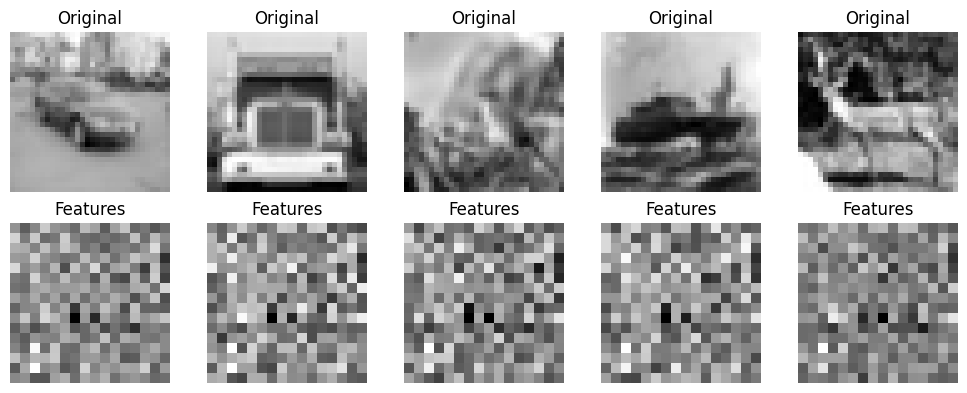

In [9]:
import matplotlib.pyplot as plt

def visualize_features(original_images, extracted_features, num_images=5):

    # Ensure the number of images does not exceed the available data
    num_images = min(num_images, len(original_images))

    plt.figure(figsize=(10, 4))

    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i].reshape(32, 32), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(extracted_features[i].reshape(16, 16), cmap='gray')
        plt.title("Features")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming `x_test` contains original images and `h_prob_test` are extracted features
# Reshape h_prob_test to have 2D spatial representation if necessary
h_prob_test_reshaped = h_prob_test.numpy().reshape(-1, 16, 16)
visualize_features(x_test, h_prob_test_reshaped)


In [10]:
# Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Define RBM
rbm = BernoulliRBM(n_components=256, learning_rate=0.01, n_iter=10, verbose=True)

# Define Logistic Regression classifier
logistic = LogisticRegression(max_iter=1000)

# Create pipeline
classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

# Train RBM and classifier
classifier.fit(x_train_scaled, y_train.ravel())

# Make predictions
y_pred = classifier.predict(x_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")

[BernoulliRBM] Iteration 1, pseudo-likelihood = -622.82, time = 38.33s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -610.50, time = 40.48s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -605.24, time = 31.82s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -593.23, time = 31.48s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -595.61, time = 31.68s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -589.91, time = 33.59s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -594.36, time = 31.98s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -591.72, time = 33.88s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -599.76, time = 31.09s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -589.75, time = 33.28s
Accuracy: 0.3591, F1-Score: 0.3543


**Interpretation**

**Original**:

These are grayscale representations of original images, possibly from a dataset like CIFAR-10 or a similar image dataset used in computer vision tasks. The images include different objects, such as vehicles, ships, and animals.

**Features**:

These images appear to represent extracted features from the original images, likely obtained using a machine learning or deep learning model (e.g., a convolutional neural network). Each image in this row shows a grid of pixel intensities that correspond to the learned or detected features from the original images above them.

**Discuss how RBM has helped in extracting more meaningful features.**

Restricted Boltzmann Machines (RBMs) help extract meaningful features by learning compact and efficient representations of the input data. By modeling the joint probability distribution of the input, RBMs capture underlying dependencies and correlations between features, such as pixels in an image, enabling the identification of global patterns like edges, textures, and shapes. This process reduces high-dimensional data, such as raw pixel intensities, into a lower-dimensional feature space that retains essential information while filtering out noise and irrelevant details. RBMs also excel at learning hierarchical features, where simple patterns like edges can combine to form more complex representations, making the extracted features as seen in the feature row of the graph more interpretable and suitable for tasks like classification or clustering.